In [1]:
# PYTHON IMPORTS
import os, copy, math
from tqdm.notebook import trange, tqdm

# IMAGE IMPORTS 
from PIL import Image

# DATA IMPORTS 
import random, h5py, glob
import numpy as np

# PLOTTING
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# SHAPES IMPORTS
from shapely.ops import unary_union
from shapely.geometry import LineString

# MY OWN CLASSES
from FindGrid import *

# PREFERENCES
Image.MAX_IMAGE_PIXELS = 933120000

In [2]:
data_dir = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data/"

prep_folder   = f"{data_dir}TileLocator/in_prepped_v2/"    
output_folder = f"{data_dir}TileLocator/out_v2/"

In [3]:
# Load the image
image_path = f'{data_dir}TileLocator/in_prepped_v2/48071CIND0A.tif'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

classifications, classModel = findKeypoints(image)
effectiveArea, effectiveAreaModel = findSquares(image)

C:\Users\fhacesga\Anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\fhacesga\Anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\fhacesga\Desktop\FIRMsDigitizing\RECTDNN\TileLocator.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)
C:\Users\fhacesga\Desktop\FIRMsDigitizing\RECTDNN\SquareLocator.py:94: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


In [4]:
image_or = cv2.imread(image_path)
image = cv2.cvtColor(image_or, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (512, 512)) 

a, b, c = identifyBiggestContour(effectiveArea[:, :, 1])
image_mask = cv2.drawContours(a[:, :, 0] * 0, contours=[c],contourIdx=-1, 
                              color=(255), thickness=cv2.FILLED)

In [5]:
# Define the target dimensions for processing
target_dim = (2400, 2400)

effectiveArea_resized = cv2.resize(effectiveArea[:, :, 1], target_dim)

# Rescale the image to the target dimensions
resized_image = cv2.resize(classifications, target_dim, interpolation=cv2.INTER_AREA)

# Convert the resized image to grayscale
threshold = 10 / 255
gray = np.logical_or(resized_image[:, :, 1].T > threshold, resized_image[:, :, 2].T > threshold) * 255
gray = gray.astype(np.uint8)

gray = cv2.ximgproc.thinning(gray, thinningType=cv2.ximgproc.THINNING_GUOHALL)

gray = np.where(effectiveArea_resized > 0, gray, 0)

# Apply Hough Transform to detect lines
degree_resolution = 25 # HOW MANY SUBDIVISIONS TO A DEGREE
line_length = 120      # HOW MANY LINES 


lines = cv2.HoughLinesP(gray, rho=1, theta=np.pi/ (180 * degree_resolution), 
                        threshold=100, 
                        minLineLength= line_length * 2, 
                        maxLineGap= line_length // 2)

lines = [line[0] for line in lines]

# Draw the detected lines on a copy of the resized image
image_with_lines = np.zeros((resized_image.shape[0], resized_image.shape[1], 3))

for line in lines:
    x1, y1, x2, y2 = line
    
    colors = np.random.randint(255, size=3).astype(np.int32)
    color = (int(colors[0]), int(colors[1]), int(colors[2])) 
    cv2.line(image_with_lines, (x1, y1), (x2, y2), color, 2)

# Rescale the image with detected lines back to the original dimensions
result_image = cv2.resize(image_with_lines, image.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

In [6]:
image_height, image_width, _ = resized_image.shape
extended_lines = extend_lines(lines, 15)
# plotLines(np.moveaxis(resized_image, 0, 1), lines)

In [7]:
scale_x, scale_y = calculate_scale_factors_large(effectiveArea.shape, target_dim)
rescaled_lines = rescale_lines(lines, scale_x, scale_y)
# plotLines(image_or, rescaled_lines)

In [8]:
angles = calcAngles(rescaled_lines)

line_angles, line_indices, sorted_idx = filterLines_MostPopularAngles(np.array(angles), 0.5)
rescaled_lines_ordered = np.array(rescaled_lines)[sorted_idx]
filtered_lines = rescaled_lines_ordered[np.concatenate(line_indices).flatten()]

# plotLines(image_or, filtered_lines)

In [9]:
extended_lines = extend_lines_to_edges(filtered_lines, image_or.shape)

# Filter lines by distance between endpoints
min_distance = 50 * np.sqrt(scale_x ** 2 + scale_y ** 2)
filtered_lines, filtered_idx = filter_lines_by_distance(extended_lines, min_distance)

In [10]:
horz_vert = splitHorizontalVertical(line_indices, filtered_idx)

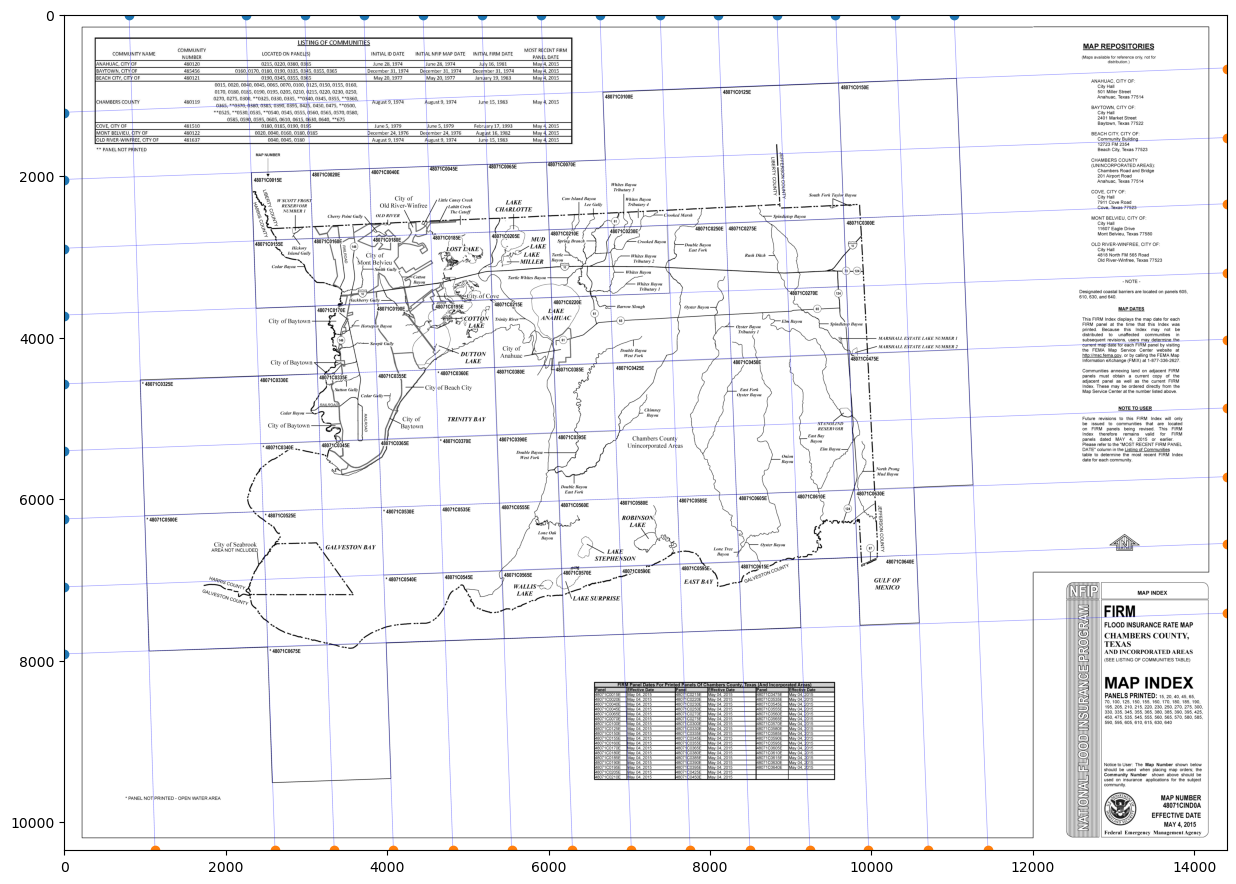

In [11]:
ax = plotLines(image_or, filtered_lines)

In [12]:
lines_shp   = lines_to_linestrings(filtered_lines)
split_lines = linestrings_to_lines(unary_union(lines_shp))

C:\Users\fhacesga\Desktop\FIRMsDigitizing\RECTDNN\FindGrid.py:300: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for linestring in linestrings:


In [24]:
scale = 2048 / np.max(list(image_or.shape))
scale_x, scale_y = scale, scale
processing_size = (int(image_or.shape[1] * scale), int(image_or.shape[0] * scale))

In [28]:
image = 255 - cv2.resize(image_or.astype(np.float32), processing_size, cv2.INTER_AREA)

In [26]:
np.max(image)

255.0

In [30]:
image = cv2.ximgproc.thinning(image.astype(np.uint8)[:,:,0], thinningType=cv2.ximgproc.THINNING_GUOHALL)

In [31]:
cv2.imwrite("tempfiles/test.png", image)

True

In [34]:
def get_overlapping_lines(lines_or, image_or, threshold, processing_size=2048):
    
    scale = processing_size / np.max(list(image_or.shape))
    scale_x, scale_y = scale, scale
    processing_size = (int(image_or.shape[1] * scale), int(image_or.shape[0] * scale))
    # print(np.min(image_or))
    # print(np.max(image_or))
    # image = cv2.ximgproc.thinning(image_or*255, thinningType=cv2.ximgproc.THINNING_GUOHALL)
    # cv72.imwrite("tempfiles/test.png", image * 255)
    # error
    image = cv2.dilate(np.array(image_or).astype(np.uint8), np.ones((3,3), np.uint8), iterations=3)
    image = cv2.resize(image.astype(np.float32), processing_size, cv2.INTER_AREA)
    image = np.where(np.array(image) > 0, 1, 0).astype(np.uint8)
    
    cv2.imwrite("tempfiles/test.png", image * 255)
    
    lines = rescale_lines(lines_or, scale_x, scale_y)
    
    # Create an empty image to mark overlapping regions
    overlap_image = np.full(image.shape, 0)
    overlap_image_fr = Image.fromarray(overlap_image.copy().astype(np.uint8))
    
    # Loop through each line
    overlapping_lines = []
    overlapping_values = []
    
    for i, line in tqdm(enumerate(lines), total=len(lines)):
                
        x1, y1, x2, y2 = [int(x) for x in line]
        print(line)
        line_image = overlap_image_fr.copy()
        line_draw = ImageDraw.Draw(line_image)
        line_draw.line((x1, y1, x2, y2), fill=1, width=5)
        
        line_image_thresh = overlap_image_fr.copy()
        line_draw = ImageDraw.Draw(line_image_thresh)
        line_draw.line((x1, y1, x2, y2), fill=1, width=1)
        
        overlap = np.logical_and(image, line_image)
        overlap_count = np.count_nonzero(overlap)
        threshold_pixels = np.count_nonzero(line_image_thresh) * threshold
        threshold_pixels = threshold_pixels if threshold_pixels != 0 else 1
        
        if True:# overlap_count >= threshold_pixels // 2:
            test = np.dstack((image, line_image, line_image_thresh))
            plt.imsave(f"tempfiles/test{i}.png", test * 255)
        
        if overlap_count >= threshold_pixels:
            overlapping_lines.append(lines_or[i])
            # draw.line((x1, y1, x2, y2), fill=1, width=1)
            
        # print(threshold_pixels)
        # print(f"{100 * overlap_count / threshold_pixels:.1f}% {overlap_count} / {threshold_pixels:.1f}")

        overlapping_values.append(overlap_count / threshold_pixels)
        
    return overlapping_lines, overlapping_values

image_or_b = np.asarray(255 - image_or) // 255

overlapping_lines, overlap_image = get_overlapping_lines(split_lines, 
                                                         image_or_b[:, :, 0], 
                                                         0.8,)

  0%|          | 0/275 [00:00<?, ?it/s]

[0.0, 172.94222222222223, 119.71079701279785, 168.36993483631673]
[119.71079701279785, 168.36993483631673, 325.2341865073715, 160.52008315423234]
[325.2341865073715, 160.52008315423234, 429.21592004358047, 156.5485586094466]
[429.21592004358047, 156.5485586094466, 533.32419570186, 152.5722008586095]
[533.32419570186, 152.5722008586095, 637.3477931032172, 148.59907734675213]
[637.3477931032172, 148.59907734675213, 740.616321575299, 144.65479327316567]
[740.616321575299, 144.65479327316567, 845.3794713152263, 140.653422970599]
[845.3794713152263, 140.653422970599, 948.7824017521814, 136.70400548863196]
[948.7824017521814, 136.70400548863196, 1054.4976990908515, 132.6662684375022]
[1054.4976990908515, 132.6662684375022, 1156.2285935493726, 128.78071344082258]
[1156.2285935493726, 128.78071344082258, 1260.1854441514904, 124.81013928588058]
[1260.1854441514904, 124.81013928588058, 1363.5671851429286, 120.86153112301314]
[1363.5671851429286, 120.86153112301314, 1468.2382712683104, 116.863677

[446.09836344227057, 633.9619170150295, 550.205873159449, 629.9638994543628]
[550.205873159449, 629.9638994543628, 654.412943154195, 625.9620585024812]
[654.412943154195, 625.9620585024812, 757.7267601228724, 621.9945209480592]
[757.7267601228724, 621.9945209480592, 863.2720020005552, 617.9412904787288]
[863.2720020005552, 617.9412904787288, 966.7201722537928, 613.9685933849759]
[966.7201722537928, 613.9685933849759, 1071.6057968592256, 609.9406940511701]
[1071.6057968592256, 609.9406940511701, 1174.5330663183536, 605.9880009948578]
[1174.5330663183536, 605.9880009948578, 1279.0415078159333, 601.9745865401243]
[1279.0415078159333, 601.9745865401243, 1382.4223989872803, 598.0044731500024]
[1382.4223989872803, 598.0044731500024, 1487.1386533355424, 593.9830781045447]
[1487.1386533355424, 593.9830781045447, 1591.230336299591, 589.9856683351616]
[1591.230336299591, 589.9856683351616, 2048.0, 572.4444444444445]
[0.0, 291.12888888888887, 123.38045303965025, 286.69061981426813]
[123.380453039

[437.66775447280247, 395.5553518948254, 441.85171227147356, 513.8721912834736]
[441.85171227147356, 513.8721912834736, 446.09836344227057, 633.9619170150295]
[446.09836344227057, 633.9619170150295, 450.28238078217845, 752.2804401517669]
[450.28238078217845, 752.2804401517669, 454.5294021128982, 872.3806335204829]
[454.5294021128982, 872.3806335204829, 458.73674820440533, 991.3588631573632]
[458.73674820440533, 991.3588631573632, 462.9430325234748, 1110.3070672621977]
[462.9430325234748, 1110.3070672621977, 475.73333333333335, 1472.0]
[735.4311111111111, 0.0, 740.616321575299, 144.65479327316567]
[740.616321575299, 144.65479327316567, 744.9062344717638, 264.3329562877518]
[744.9062344717638, 264.3329562877518, 749.1826859779234, 383.6355791684836]
[749.1826859779234, 383.6355791684836, 753.4454115302239, 502.5552812340065]
[753.4454115302239, 502.5552812340065, 757.7267601228724, 621.9945209480592]
[757.7267601228724, 621.9945209480592, 761.9856790387186, 740.808027090936]
[761.98567903

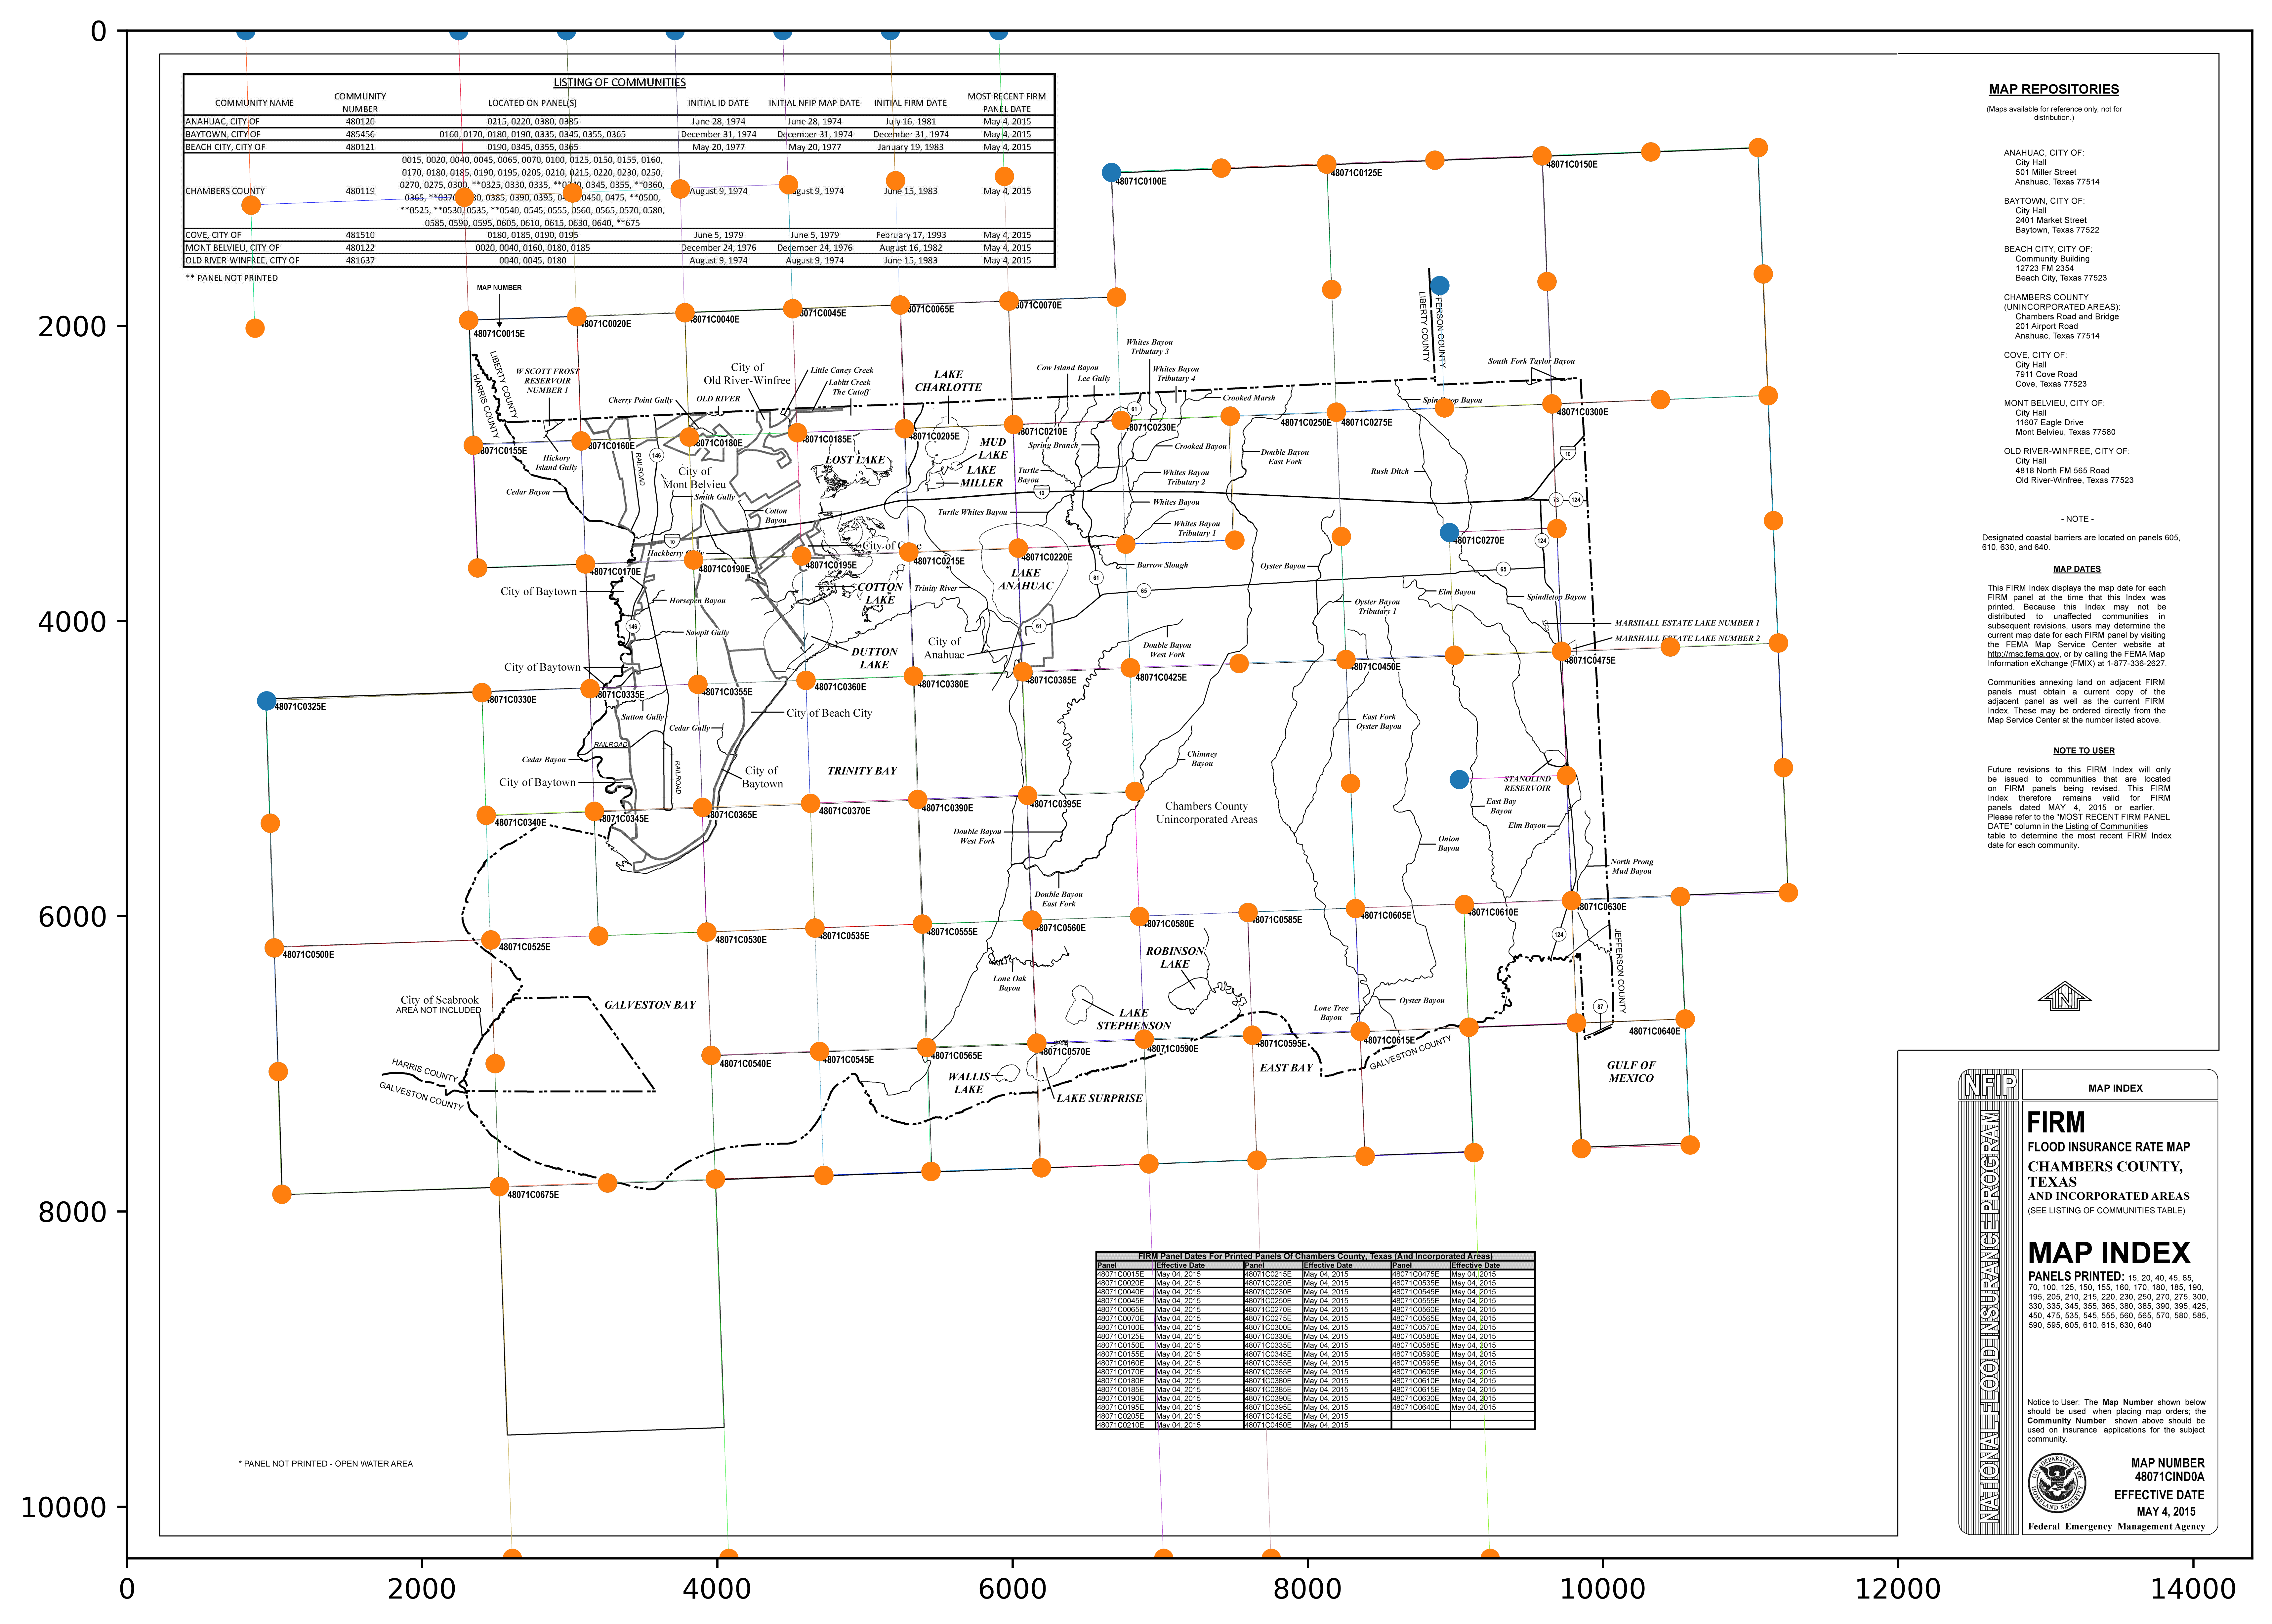

In [35]:
fig, ax = plt.subplots(figsize=(15,10), dpi=600)
ax = plotLines(image_or, overlapping_lines, color=False, ax=ax)

fig.savefig("test.png")

In [38]:
import pytesseract
from fuzzywuzzy import fuzz
import re

C:\Users\fhacesga\Anaconda3\envs\deeplearning\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [78]:
t_path = r'C:\Users\fhacesga\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
pytesseract.pytesseract.tesseract_cmd = t_path

In [75]:
def draw_lines_to_image(lines, image_size, line_color=(255), background_color=(0)):
    """
    Draw lines on an image using ImageDraw.

    Args:
        lines (list): List of lines, where each line is defined as (x0, y0, x1, y1).
        image_size (tuple): Size of the output image (width, height).
        line_color (tuple): Color of the lines (R, G, B).
        background_color (tuple): Background color of the image (R, G, B).

    Returns:
        Image: PIL Image object with the drawn lines.
    """
    # Create a new image with the specified background color
    image = Image.new("L", image_size, background_color)
    
    # Initialize ImageDraw object
    draw = ImageDraw.Draw(image)
    
    # Draw each line on the image
    for x0, y0, x1, y1 in lines:
        draw.line((x0, y0, x1, y1), fill=line_color)
    
    return np.asarray(image)

bw_bounds = draw_lines_to_image(overlapping_lines, (image_or.shape[1], image_or.shape[0]))

In [77]:
contours, hierarchy = cv2.findContours(bw_bounds, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

In [76]:
filled_image = np.zeros(image_or.shape)

# Fill innermost contours with random colors
for idx, contour in enumerate(contours):
    if hierarchy[0][idx][3] == 0:  # If contour has no child contours
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.drawContours(filled_image, [contour], -1, color, thickness=cv2.FILLED)
cv2.imwrite("test.png", filled_image)

True

In [87]:
outdict = {}

key = '48071'

def find_word_with_key(text, key):
    pattern = r'\b\w*' + re.escape(key) + r'\w*\b'  # Regular expression pattern
    match = re.search(pattern, text, flags=re.IGNORECASE)
    if match:
        return match.group()
    else:
        return None

for idx, contour in tqdm(enumerate(contours), total=len(contours)):
    if hierarchy[0][idx][3] == 0:  # If contour has no child contours
        x, y, w, h = cv2.boundingRect(contour)
    
        # Crop the contour region from the image
        cropped_region = image_or[y:y+h, x:x+w]
    
        # Perform OCR using pytesseract
        ocr_text = pytesseract.image_to_string(cropped_region,
                                              config='--psm 1 --oem 3 -c tessedit_char_whitelist=0123456789')
        
        text = find_word_with_key(ocr_text, key)
        
        if text is None:
            print(text)
            continue
        
        outdict[text] = contour

  0%|          | 0/64 [00:00<?, ?it/s]

None
None
None
None
None
None
None
None
None
None


In [90]:
outdict

{'4807100540': array([[[4677, 6916]],
 
        [[4678, 6915]],
 
        [[4679, 6915]],
 
        ...,
 
        [[4674, 6916]],
 
        [[4675, 6916]],
 
        [[4676, 6916]]], dtype=int32),
 '4807100545': array([[[5403, 6889]],
 
        [[5404, 6888]],
 
        [[5405, 6888]],
 
        ...,
 
        [[5400, 6889]],
 
        [[5401, 6889]],
 
        [[5402, 6889]]], dtype=int32),
 '4807100565': array([[[6150, 6861]],
 
        [[6151, 6860]],
 
        [[6152, 6860]],
 
        ...,
 
        [[6147, 6861]],
 
        [[6148, 6861]],
 
        [[6149, 6861]]], dtype=int32),
 '4807100570': array([[[6877, 6834]],
 
        [[6878, 6833]],
 
        [[6879, 6833]],
 
        ...,
 
        [[6874, 6834]],
 
        [[6875, 6834]],
 
        [[6876, 6834]]], dtype=int32),
 '4807100590': array([[[7610, 6807]],
 
        [[7611, 6806]],
 
        [[7612, 6806]],
 
        ...,
 
        [[7607, 6807]],
 
        [[7608, 6807]],
 
        [[7609, 6807]]], dtype=int32),
 '48071005